In [1]:
# Imports
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from langdetect import detect, detect_langs # for language detection
from tqdm.notebook import tqdm, trange
import time
import math
from collections import Counter
import spacy
import pickle
import ast
from collections import Counter

In [2]:
# GLOBAL VARIABLES
PLOT_DIMS = (11.7, 8.27)
TITLE_SIZE = 30
LABEL_SIZE = 25
TICK_SIZE=20

# BLOGS

In [3]:
# Data path
# raw_csv_path = '../../data/bnc/bnc_subset_19_29_vs_50_plus_nfiles_0_rand_balanced.csv'
raw_csv_path = '../../data/blogs_kaggle/blogtext.csv'
# data_tag = 'bnc_rb'
data_tag = 'blog'

In [4]:
# Preprocessing function
def preprocess_df(df, data='blog'):

    data_size = len(df)

    #TODO Pre-processing steps happen here -- implement them st the less
    # standard ones can be switched on and off to evaluate their impact on
    # performance:
    # Remove all non-alphabetical characters
#     df['clean_text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ', x))
    df['clean_text'] = df['text']

    # make all letters lowercase
    df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())

    # remove whitespaces from beginning or ending
    df['clean_text'] = df['clean_text'].apply(lambda x: x.strip())

    # remove stop words
#     stopwords_dict = set(stopwords.words('english')) # use set (hash table) data structure for faster lookup
#     df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords_dict]))

    # Remove instances empty strings
    df.drop(df[df.clean_text == ''].index, inplace = True)

    # TODO: filter out non-English

    # TODO: mask age-disclosing utterances

    # number of datapoints removed by all pre-processing steps
    dropped_instances = data_size - len(df)
    data_size = len(df)


    if data == 'blog':
        # Add labels for age categories
        def age_to_cat(age):
            '''Returns age category label for given age number.'''

            if 13 <= int(age) <= 17:
                return '13-17' # 0
            elif 23 <= int(age) <= 27:
                return '23-27' # 1
            elif 33 <= int(age):
                return '33-47' # 2
            else:
                raise ValueError("Given age not in one of pre-defined age groups.")

        df['age_cat'] = df['age'].apply(age_to_cat)

    elif data == 'bnc' or data == 'bnc_rb':

        # Add labels for age categories
        def age_to_cat(label):
            '''Returns age category label for given age number.'''

            if label == '19_29':
                return '19-29' # 0
            elif label == '50_plus':
                return '50-plus' # 1
            else:
                raise ValueError("Given age not in one of pre-defined age groups.")

        df['age_cat'] = df['label'].apply(age_to_cat)

        # # rename column
        # df.rename(columns={'label': 'age_cat'}, inplace=True)

    # import pdb
    # pdb.set_trace()
#     return df[['clean_text', 'age_cat']]
    return df


In [5]:
# Read csv to dataframe
print('Loading data...')
df = pd.read_csv(raw_csv_path, encoding="utf-8")  # to keep no. unique chars consistent across platforms

# Preprocess data
print('Preprocessing data...')
df_pp = preprocess_df(df=df, data=data_tag)
df_pp.reset_index(drop=True, inplace=True)
print('Done preprocessing data.')

Loading data...
Preprocessing data...
Done preprocessing data.


In [6]:
df_pp.head()

,id,gender,age,topic,sign,date,text,clean_text,age_cat
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages, and 4.5 mb...",13-17
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewes van der l...,13-17
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde: maak je ...,13-17
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!,13-17
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can now 'capture'...,33-47


In [7]:
# Add length column for clean text
df_pp['clean_length'] = df_pp['clean_text'].apply(lambda x: len(x.split()))

In [8]:
df_pp.head()

,id,gender,age,topic,sign,date,text,clean_text,age_cat,clean_length
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages, and 4.5 mb...",13-17,28
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewes van der l...,13-17,20
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde: maak je ...,13-17,4326
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!,13-17,2
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can now 'capture'...,33-47,65


In [9]:
df_pp['clean_length'].describe()

count    678165.000000
mean        201.710196
std         415.890346
min           1.000000
25%          38.000000
50%         113.000000
75%         256.000000
max      131169.000000
Name: clean_length, dtype: float64

In [10]:
df_pp['text'][(df.clean_length == 131169)].to_csv("max_len_blog.txt")

In [11]:
678165 * 201.710196

136792795.07034

In [12]:


b, c = df_pp.iloc[4].copy(), df_pp.iloc[95].copy()
df_pp.iloc[4],df_pp.iloc[95] = c,b

## Distribution wrt Age brackets

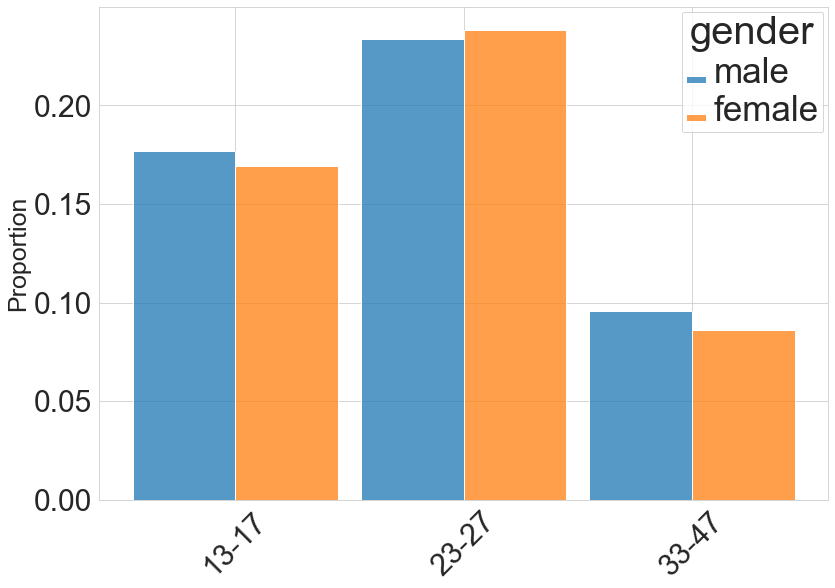

In [13]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(df_pp, x = "age_cat", stat = "probability", hue='gender', multiple='dodge', shrink=0.9)
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("BAC age by gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Proportion", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/blog_age_gender_dist.png')

In [14]:
df_pp.topic.describe()

count     678165
unique        40
top       indUnk
freq      249887
Name: topic, dtype: object

In [15]:
df_pp.topic.value_counts(normalize=True)

indUnk                     0.368475
Student                    0.226166
Technology                 0.061721
Arts                       0.047624
Education                  0.043624
Communications-Media       0.029513
Internet                   0.023485
Non-Profit                 0.021574
Engineering                0.016988
Law                        0.013214
Publishing                 0.011372
Science                    0.010638
Government                 0.010088
Consulting                 0.008617
Religion                   0.007684
Fashion                    0.007132
Marketing                  0.006948
Advertising                0.006867
BusinessServices           0.006597
Banking                    0.005953
Chemicals                  0.005767
Telecommunications         0.005711
Accounting                 0.005636
Military                   0.004580
Museums-Libraries          0.004553
Sports-Recreation          0.004455
HumanResources             0.004428
RealEstate                 0

In [16]:
# Grouping topics that account for less than 1% of the topic distribution's density into one category, 'Other'
def topic_to_cat(topic):
    
    if topic == 'indUnk':
        return 'unknown'
    elif topic == 'Student':
        return 'student'
    elif topic == "Technology":
        return 'technology'
    elif topic == 'Education':
        return 'education'
    elif topic == 'Arts':
        return 'arts'
    elif topic == 'Communications-Media':
        return 'com_media'
    elif topic == 'Internet':
        return 'internet'
    elif topic == 'Non-Profit':
        return 'non_profit'
    elif topic == 'Engineering':
        return 'engineering'
    elif topic == 'Law':
        return 'law'
    elif topic == 'Publishing':
        return 'publishing'
    elif topic == 'Science':
        return 'science'
    elif topic == 'Government':
        return 'government'
    else:
        return 'other'

# Communications-Media       0.029558
# Internet                   0.023354
# Non-Profit                 0.021598
# Engineering                0.016883
# Law                        0.013575
# Publishing                 0.011659
# Science                    0.010627
# Government                 0.010087

df_pp['topic_cat'] = df_pp['topic'].apply(topic_to_cat)

In [17]:
# df_pp_temp = df_pp[(df_pp['topic_cat'] != 'unknown')]
df_pp_temp = df_pp

In [18]:
df_pp_temp.reset_index(drop=True, inplace=True)

In [19]:
df_pp_temp

,id,gender,age,topic,sign,date,text,clean_text,age_cat,clean_length,topic_cat
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages, and 4.5 mb...",13-17,28,student
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members: drewes van der l...,13-17,20,student
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde: maak je ...,13-17,4326,student
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing!!! testing!!!,13-17,2,student
4,4172416,female,25,indUnk,Capricorn,"08,August,2004","urlLink im new to this, ...","urllink im new to this, can you tell!- god...",23-27,16,unknown
...,...,...,...,...,...,...,...,...,...,...,...
678160,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ...","dear susan, i could write some really bitter ...",23-27,40,student
678161,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i...","dear susan, 'i have the second yeast infectio...",23-27,67,student
678162,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin...","dear susan, your 'boyfriend' is fucking bald!...",23-27,11,student
678163,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as...","dear susan: just to clarify, i am asking yo...",23-27,65,student


In [20]:
# b, c = df_pp_temp.iloc[4].copy(), df_pp_temp.iloc[678160].copy()
# df_pp_temp.iloc[4],df_pp_temp.iloc[427621] = c,b

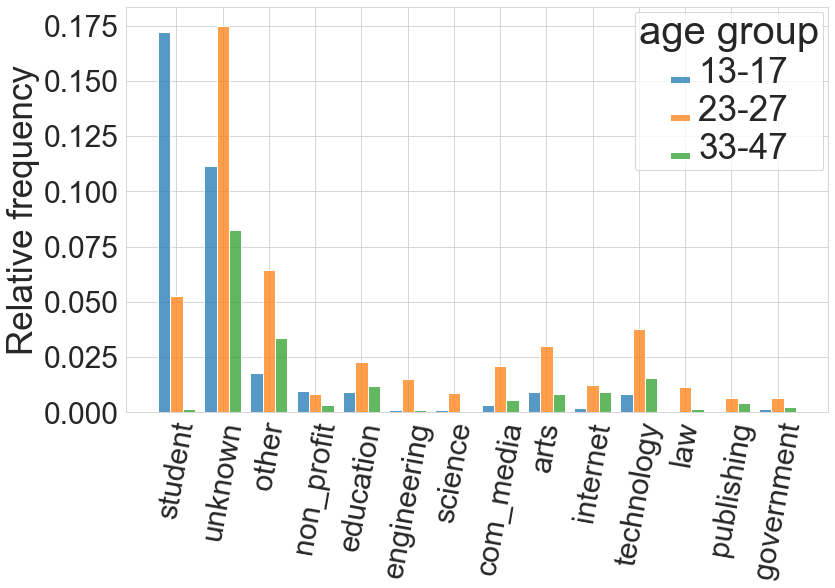

In [24]:
plt.figure(figsize=PLOT_DIMS)
# sns.heatmap(pd.crosstab(df_pp.age_cat, df_pp.topic_cat), annot=True, fmt='g', cmap = 'Blues')
df_pp_temp.rename(columns={'age_cat': 'age group'}, inplace=True)
hist = sns.histplot(df_pp_temp, x = 'topic_cat', hue='age group', stat='probability', multiple='dodge', shrink=0.8)
df_pp_temp.rename(columns={'age group': 'age_cat'}, inplace=True)
sns.set_style("whitegrid")
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
plt.xticks(rotation=80, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
plt.title("", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Relative frequency", fontsize = LABEL_SIZE + 10)
plt.tight_layout()
plt.savefig('../../figures/paper/blog_age_topic_histogram.png')

In [26]:
0.742-0.472

0.27

In [ ]:
plt.figure(figsize=PLOT_DIMS)
sns.heatmap(pd.crosstab(df_pp.age_cat, df_pp.topic_cat), annot=True, fmt='g', cmap = 'Blues', square=True,
           cbar_kws={"orientation": "horizontal"}, cbar=False)
# hist = sns.histplot(df_pp, x = 'topic_cat', hue='age_cat', stat='probability', multiple='dodge', shrink=0.8)
# sns.set_style("whitegrid")
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
plt.xticks(rotation=80, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("Blog topics by age group", fontsize = TITLE_SIZE)
plt.xlabel("Blog topic", fontsize = LABEL_SIZE)
plt.ylabel("Age bracket", fontsize = LABEL_SIZE)
plt.tight_layout()
# plt.savefig('../../figures/paper/blog_age_topic_heatmap.png')

In [ ]:
plt.figure(figsize=PLOT_DIMS)
# sns.heatmap(pd.crosstab(df_pp.age_cat, df_pp.topic_cat), annot=True, fmt='g', cmap = 'Blues')
# df_pp_temp.rename(columns={'age_cat': 'age group'}, inplace=True)
hist = sns.histplot(df_pp_temp, x = 'topic_cat', hue='age group', stat='probability', multiple='dodge', shrink=0.8)
# df_pp_temp.rename(columns={'age group': 'age_cat'}, inplace=True)
sns.set_style("whitegrid")
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
plt.xticks(rotation=80, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("Blog topics by age group", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Relative frequency", fontsize = LABEL_SIZE + 10)
plt.tight_layout()
plt.savefig('../../figures/paper/blog_age_topic_histogram.png')

## BNC_RB

In [ ]:
# Data path
# raw_csv_path = '../../data/bnc/bnc_subset_19_29_vs_50_plus_nfiles_0_rand_balanced.csv'
# raw_csv_path = '../../data/blogs_kaggle/blogtext.csv'
raw_csv_path ='subsets/bnc_subset_19_29_vs_50_plus_nfiles_0_w_gender_topics.csv'
# raw_csv_path ='../../data/bnc/bnc_subset_19_29_vs_50_plus_nfiles_0.csv'
data_tag = 'bnc_rb'
# data_tag = 'blog'

In [ ]:
# Read csv to dataframe
print('Loading data...')
df = pd.read_csv(raw_csv_path, encoding="utf-8")  # to keep no. unique chars consistent across platforms

# Preprocess data
print('Preprocessing data...')
df_pp = preprocess_df(df=df, data=data_tag)
df_pp.reset_index(drop=True, inplace=True)
print('Done preprocessing data.')

In [ ]:
df_pp.head()

In [ ]:
# Add length column for clean text
df_pp['clean_length'] = df_pp['clean_text'].apply(lambda x: len(x.split()))

In [ ]:
df_pp.head()

In [ ]:
# df_pp.label[2000]

b, c = df_pp.iloc[0].copy(), df_pp.iloc[2000].copy()
df_pp.iloc[0],df_pp.iloc[2000] = c,b

In [ ]:
len(df_pp)

In [ ]:
df_pp['clean_length'].describe()

### Distribution wrt age brackets

In [ ]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
df_pp["gender"].replace({"M": "male", "F": "female"}, inplace=True)
hist = sns.histplot(df_pp, x = "label", stat = "probability", hue='gender', multiple='dodge', shrink=0.9)
df_pp["gender"].replace({"male": "M", "female": "F"}, inplace=True)
# for legend title and fontsizes

plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
# plt.hist(df_pp['age_cat'])
plt.xticks(rotation=45, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("BNC age by gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Proportion", fontsize = LABEL_SIZE + 10)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

In [ ]:
df_pp.clean_length.describe()

In [ ]:
# Per age group
df_pp.clean_length[df_pp['label'] == '50_plus'].describe()

In [ ]:
# Per age group
df_pp.clean_length[df_pp['label'] == '19_29'].describe()

In [ ]:
sum(df_pp.clean_length[df_pp['label'] == '19_29'])

In [ ]:
sum(df_pp.clean_length[df_pp['label'] == '50_plus'])

In [ ]:
# Add length column for raw text
df_pp['raw_length'] = df_pp['text'].apply(lambda x: len(x.split()))

In [ ]:
df_pp.raw_length.describe()

In [ ]:
sum(df_pp['raw_length'])

In [ ]:
df_pp.raw_length.quantile(0.90)

In [ ]:
381195 + 406157

In [ ]:
quantiles = []
# for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.60, 0.70, 0.80, 0.90, 0.99]:
for q in [0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:    
    quantile = df_pp.raw_length.quantile(q)
    quantiles.append(quantile)
    print(f" {q*100}% = {quantile}")

In [ ]:
quantiles

In [ ]:
test_arr = []

for length in quantiles:
    test_arr = test_arr + 15*[length]
    
test_arr = np.array(test_arr)

In [ ]:
for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.60, 0.70, 0.80, 0.90, 0.99]:
# for q in [0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:    
    quantile = np.quantile(test_arr, q)
    print(f" {q*100}% = {np.round(quantile, 0)}")

In [ ]:
len(test_arr)

In [ ]:
# Density Plot and Histogram of no. tokens per utterance
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.distplot(df_pp['raw_length'], hist=True, kde=True, 
             bins=int(180), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_title("Distribution of number of tokens per utterance.", size=LABEL_SIZE)
ax.set_xlabel("No. tokens per utterance", size=LABEL_SIZE)
ax.set_ylabel("Density", size=LABEL_SIZE)
plt.xlim(0, 83)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')

## Topics

In [ ]:
topics_set = set()
all_topics_list = []
topics_counter = Counter
for topic_list in df_pp.topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    topics_set.update(topic_list)
    all_topics_list = all_topics_list + topic_list

In [ ]:
len(topics_set)

In [ ]:
# df_check = pd.read_csv('../../data/bnc/bnc_subset_19_29_vs_50_plus_nfiles_0_rand_balanced.csv', encoding="utf-8")  # to keep no. unique chars consistent across platforms

# nu_19 = df_check[df_check.label == '19_29']['speaker_id'].nunique()
# nu_50 = df_check[df_check.label == '50_plus']['speaker_id'].nunique()
# print(f'No. unique speakers in range 19_29: {nu_19}')
# print(f'No. unique speakers in range 50_plus: {nu_50}')

In [ ]:
# Topic counter
topic_counter = Counter(all_topics_list)

In [ ]:
# Percentage of topics with more than one occurrence
topics_1_occ = [(topic, freq) for topic, freq in topic_counter.most_common() if freq == 1]
print(f"{((len(topic_counter) - len(topics_1_occ)) / len(topic_counter)) * 100}% of topics have more than 1 occurrence.")

In [ ]:
# topic_counter.most_common()

# [('food', 10638),
#  ('work', 10425),
#  ('friends', 9010),
#  ('family', 6342),
#  ('relationships', 5033),
#  ('future plans', 4974),
#  ('no info', 4181),
#  ('holidays', 4123),
#  ('university', 2999),
#  ('cooking', 2612),
#  ('', 2198),
#  ('travelling', 2051),
#  ('health', 1814),
#  ('ex boyfriends', 1662),
#  ('tv', 1569),
#  ('catch up', 1567),
#  ('marriage', 1545),
#  ('shopping', 1513),
#  ('weather', 1472),
#  ('tv shows', 1468),
#  ('scottish referendum', 1423),
#  ('cars', 1406),
#  ('films', 1385),
#  ('job interview', 1310),
#  ('colleague', 1310)]

In [ ]:
top_10_topics_counts = [('food', 10638),
 ('work', 10425),
 ('friends', 9010),
 ('family', 6342),
 ('relationships', 5033),
 ('future plans', 4974),
 ('no info', 4181),
 ('holidays', 4123),
 ('university', 2999),
 ('cooking', 2612),('travelling', 2051),
 ('health', 1814),
 ('ex boyfriends', 1662),
 ('tv', 1569),
 ('catch up', 1567),
 ('marriage', 1545)]


# top_10_topics_counts =[('food', 10638),
#  ('work', 10425),
#  ('friends', 9010),
#  ('family', 6342),
#  ('relationships', 5033),
#  ('future plans', 4974),
#  ('no info', 4181),
#  ('holidays', 4123),
#  ('university', 2999),
#  ('cooking', 2612),
#  ('travelling', 2051),
#  ('health', 1814),
#  ('ex boyfriends', 1662),
#  ('tv', 1569),
#  ('catch up', 1567),
#  ('marriage', 1545),
#  ('shopping', 1513),
#  ('weather', 1472), ('tv shows', 1468)]

In [ ]:
top_10_topics_list = [topic for topic, freq in top_10_topics_counts]


In [ ]:
top_10_topics_list

In [ ]:
def freq_topic_col(topic_list, top_topic_list=top_10_topics_list):
    
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    overlap = [topic for topic in topic_list if topic in top_topic_list]
    
    if overlap == []:
        overlap = 'none'
        return overlap
    else:
        return overlap[0]

df_pp['freq_topics'] = df_pp['topics'].apply(freq_topic_col)

In [ ]:
# topic_list = df_pp.topics[500]
# topic_list = ast.literal_eval(topic_list)
# topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
# overlap = [topic for topic in topic_list if topic in top_10_topics_list]
# df_pp

In [ ]:
# df_pp_temp = df_pp[(df_pp['freq_topics'] != 'none') & (df_pp['freq_topics'] != 'no info')]
df_pp_temp = df_pp

In [ ]:
df_pp_temp.freq_topics.describe()

In [ ]:
plt.figure(figsize=PLOT_DIMS)
# sns.heatmap(pd.crosstab(df_pp.age_cat, df_pp.topic_cat), annot=True, fmt='g', cmap = 'Blues')
df_pp_temp.rename(columns={'label': 'age group'}, inplace=True)
hist = sns.histplot(df_pp_temp, x = 'freq_topics', hue='age group', stat='probability', multiple='dodge', shrink=0.8)
df_pp_temp.rename(columns={'age group': 'label'}, inplace=True)
sns.set_style("whitegrid")
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
plt.xticks(rotation=80, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("BNC topics by age group", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE + 10)
plt.ylabel("Relative frequency", fontsize = LABEL_SIZE + 10)
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_age_topic_histogram.png')

In [ ]:
# plt.rcParams.keys()

## Case analysis


In [ ]:
case_df = pd.read_csv('../../data/bnc/bnc_rb_10p_testset_case_analysis_final.csv', encoding="utf-8")

In [ ]:
case_df.head()

In [ ]:
# trigram was right
len(case_df.loc[case_df.trigram_pred == case_df.label]) / len(case_df)

In [ ]:
sum(case_df.bert_pred == case_df.label) / len(case_df)

In [ ]:
len(case_df)

## Dialogue recovery of utterances selected by Sandro

In [ ]:
## 19-29
# snippet = "you'd need a crazy curriculum"
# snippet = "oh that's cool"
# snippet = 'different sights and stuff'
# snippet = "yeah I know I can imagine like a big erm"

## 50 plus
# snippet = 'right yes definitely and then yes it just came in the door'
# snippet = "I said no I don't have them"
snippet = "that's of course"

In [ ]:
conv_id = df_pp[df_pp.text == snippet].conv_id.item()

In [ ]:
conv_id

In [ ]:
turn = df_pp[df_pp.text == snippet].turn.item()
age = df_pp[df_pp.text == snippet].age_cat.item()
print(turn)
print(age)

In [ ]:
conv_df = df_pp[df_pp.conv_id == conv_id]

In [ ]:
# conv_df.to_csv(f'../../analyses/sample_dialogues/sample_conv_5_age_{age}_turn_{turn}.csv', index=False)

In [ ]:
shee

### Imbalanced BNC